# Neural network to learn conservative to primitive conversion

<u>**This is the script used that was used as a prompt for the SRHD Prompt 5**.</u> (Or actually, the converted notebook was used as the input. The conversion can be done with teh first cell in this notebook)

We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to approximate the function $f$ that we define in this notebook.

Use this first cell to convert the notebook to a python script.

In [1]:
!jupyter nbconvert script.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

[NbConvertApp] Converting notebook script.ipynb to script
[NbConvertApp] Writing 20370 bytes to script.py


In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import tensorboardX as tbx


## Generating the data

In [15]:
# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generating the data
np.random.seed(0)
x = np.random.uniform(-10, 10, size=(10000, 3))
y = 2 * x[:, 0] - 3 * x[:, 1] + 5 * x[:, 2] + np.random.normal(0, 1, size=10000)

# Splitting the data into train and test sets
x_train = torch.tensor(x[:8000], dtype=torch.float32).to(device) # Added moving the tensor to the device
y_train = torch.tensor(y[:8000], dtype=torch.float32).to(device) # Added moving the tensor to the device
x_test = torch.tensor(x[8000:], dtype=torch.float32).to(device) # Added moving the tensor to the device
y_test = torch.tensor(y[8000:], dtype=torch.float32).to(device) # Added moving the tensor to the device


## Checking and visualizing the data

Number of NaN values in x: 0
Number of NaN values in y: 0


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'x0')

Text(0, 0.5, 'y')

<Axes: >

Text(0.5, 0, 'x1')

Text(0, 0.5, 'y')

<Axes: >

Text(0.5, 0, 'x2')

Text(0, 0.5, 'y')

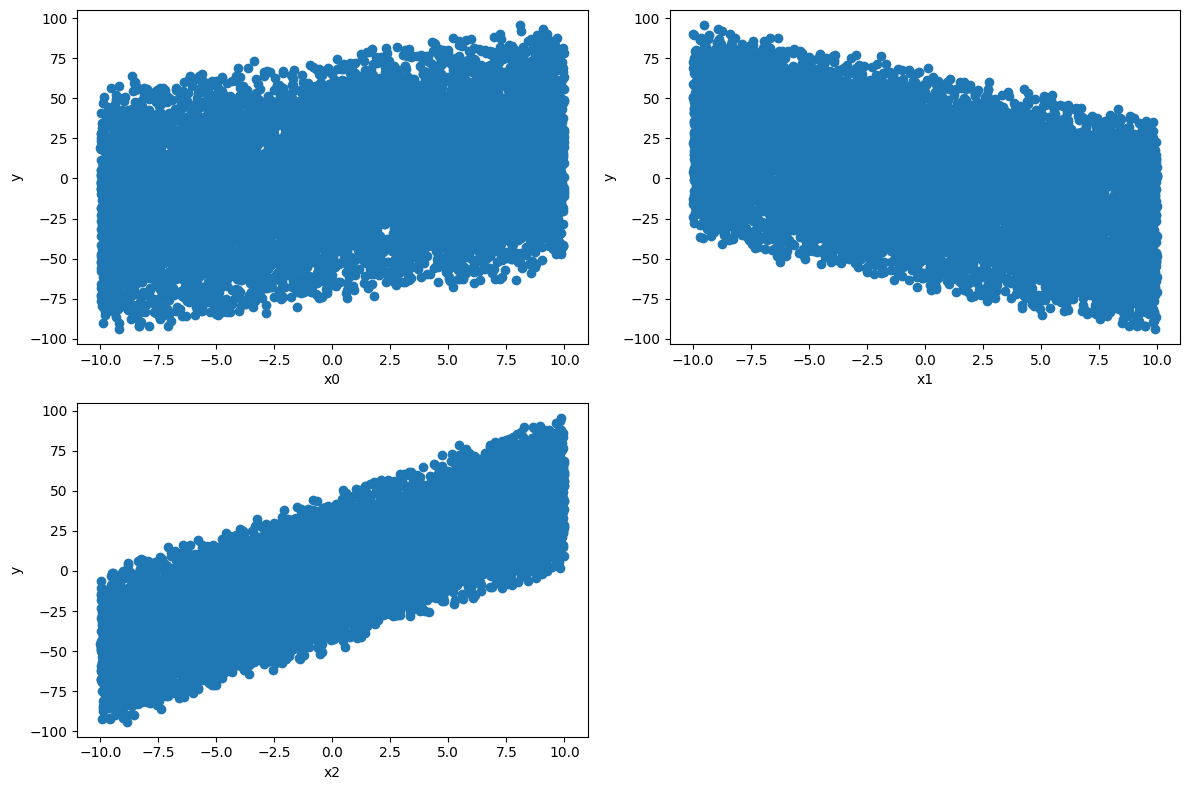

Mean and standard deviation of x_train: tensor(-0.0730) tensor(5.8088)
Mean and standard deviation of y_train: tensor(0.0441) tensor(35.7456)
Mean and standard deviation of x_test: tensor(0.0390) tensor(5.7697)
Mean and standard deviation of y_test: tensor(0.0522) tensor(35.1231)


In [27]:
# Checking for NaN values in the data
print("Number of NaN values in x:", np.isnan(x).sum())
print("Number of NaN values in y:", np.isnan(y).sum())

# Plotting the input and output variables
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x[:, 0], y)
plt.xlabel("x0")
plt.ylabel("y")
plt.subplot(2, 2, 2)
plt.scatter(x[:, 1], y)
plt.xlabel("x1")
plt.ylabel("y")
plt.subplot(2, 2, 3)
plt.scatter(x[:, 2], y)
plt.xlabel("x2")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Computing the mean and standard deviation of the data
print("Mean and standard deviation of x_train:", torch.mean(x_train), torch.std(x_train))
print("Mean and standard deviation of y_train:", torch.mean(y_train), torch.std(y_train))
print("Mean and standard deviation of x_test:", torch.mean(x_test), torch.std(x_test))
print("Mean and standard deviation of y_test:", torch.mean(y_test), torch.std(y_test))


## Defining the neural network class

In [16]:

# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))

        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x


## Setting the search space

In [17]:
# Defining a function to create a trial network and optimizer
def create_model(trial):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler), where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler.
    """

    # Sampling the hyperparameters from the search space
    n_layers = trial.suggest_int("n_layers", 1, 5)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    n_units = [trial.suggest_int(f"n_units_{i}", 1, 256) for i in range(n_layers)]
    hidden_activation_name = trial.suggest_categorical("hidden_activation", ["ReLU", "Tanh", "Sigmoid"])
    output_activation_name = trial.suggest_categorical("output_activation", ["ReLU", "Tanh", "Sigmoid"])
    # Added another common loss function: CrossEntropyLoss
    loss_name = trial.suggest_categorical("loss", ["MSE", "MAE", "Huber", "CrossEntropy"])
    # Added another common optimizer: Adagrad
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop", "Adagrad"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    batch_size = trial.suggest_int("batch_size", 1, 512)
    # Increased the maximum number of epochs that are tried
    n_epochs = trial.suggest_int("n_epochs", 10, 200)
    # Added the possibility of having different schedulers: CosineAnnealingLR and ReduceLROnPlateau
    scheduler_name = trial.suggest_categorical("scheduler", ["None", "StepLR", "ExponentialLR", "CosineAnnealingLR", "ReduceLROnPlateau"])

    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Tanh":
        output_activation = nn.Tanh()
    else:
        output_activation = nn.Sigmoid()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss()
    else:
        # Added creating the CrossEntropyLoss function
        loss_fn = nn.CrossEntropyLoss()

    # Creating the network with the sampled hyperparameters
    net = Net(n_layers, n_units, hidden_activation, output_activation).to(device) # Added moving the network to the device

    # Creating the optimizer from its name
    if optimizer_name == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=lr)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=lr)
    else:
        # Added creating the Adagrad optimizer
        optimizer = optim.Adagrad(net.parameters(), lr=lr)

    # Creating the learning rate scheduler from its name
    if scheduler_name == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_name == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    elif scheduler_name == "CosineAnnealingLR":
        # Added creating the CosineAnnealingLR scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    elif scheduler_name == "ReduceLROnPlateau":
        # Added creating the ReduceLROnPlateau scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)
    else:
        scheduler = None

    # Returning the network, the loss function, the optimizer, the batch size, the number of epochs and the scheduler
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler


## The train and eval loop

In [25]:
# Defining a function to train and evaluate a network on the train and test sets
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler):
    """Trains and evaluates a network on the train and test sets.

    Args:
        net (Net): The network to train and evaluate.
        loss_fn (torch.nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        batch_size (int): The batch size to use.
        n_epochs (int): The number of epochs to train for.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.

    Returns:
        tuple: A tuple of (train_losses, test_losses,
            train_accuracies, test_accuracies), where train_losses and test_losses are lists of average losses per epoch for the train and test sets,
            train_accuracies and test_accuracies are lists of average accuracies per epoch for the train and test sets.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size)

    # Initializing lists to store the losses and accuracies for each epoch
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Looping over the epochs
    for epoch in range(n_epochs):
        # Setting the network to training mode
        net.train()
        # Initializing variables to store the total loss and correct predictions for the train set
        train_loss = 0.0
        train_correct = 0
        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:
            # Zeroing the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = net(x_batch)
            # Reshaping the target tensor to match the input tensor
            y_batch = y_batch.view(-1, 1)
            # Computing the loss
            loss = loss_fn(y_pred, y_batch)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # Updating the total loss and correct predictions
            train_loss += loss.item() * x_batch.size(0)
            train_correct += torch.sum((y_pred - y_batch).abs() < 1e-3)

        # Setting the network to evaluation mode
        net.eval()
        # Initializing variables to store the total loss and correct predictions for the test set
        test_loss = 0.0
        test_correct = 0
        # Looping over the batches in the test set
        for x_batch, y_batch in test_loader:
            # Forward pass
            y_pred = net(x_batch)
            # Reshaping the target tensor to match the input tensor
            y_batch = y_batch.view(-1, 1)
            # Computing the loss
            loss = loss_fn(y_pred, y_batch)
            # Updating the total loss and correct predictions
            test_loss += loss.item() * x_batch.size(0)
            test_correct += torch.sum((y_pred - y_batch).abs() < 1e-3)

        # Computing the average losses and accuracies for the train and test sets
        train_loss /= len(x_train)
        test_loss /= len(x_test)
        train_accuracy = train_correct / len(x_train)
        test_accuracy = test_correct / len(x_test)

        # Appending the losses and accuracies to the lists
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Updating the learning rate scheduler with validation loss if applicable
        if scheduler is not None: # Added checking if scheduler is not None
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss) # Added passing validation loss as metric value
            else:
                scheduler.step()

        # Printing the epoch summary
        print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Returning the lists of losses and accuracies
    return train_losses, test_losses, train_accuracies, test_accuracies


In [20]:
# Defining a function to compute the objective value for a trial
def objective(trial):
    """Computes the objective value (final test loss) for a trial.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The objective value (final test loss) for the trial.
    """
    # Creating a trial network and optimizer with the create_model function
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler = create_model(trial)

    # Training and evaluating the network with the train_and_eval function
    train_losses, test_losses, train_accuracies, test_accuracies = train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler)

    # Returning the final test loss as the objective value
    return test_losses[-1]



## Finding the best hyperparameters with Optuna

In [26]:
# Creating a study object with Optuna
study = optuna.create_study(direction="minimize")

# Running the optimization for 100 trials
study.optimize(objective, n_trials=100)


[I 2023-05-04 19:29:05,378] A new study created in memory with name: no-name-d4314516-045b-423b-aea4-9feb086c89d9
/tmp/ipykernel_27400/1147161505.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)


Epoch 1: Train Loss: 28.9927, Train Accuracy: 0.0000, Test Loss: 28.1356, Test Accuracy: 0.0000
Epoch 2: Train Loss: 28.9240, Train Accuracy: 0.0000, Test Loss: 28.0342, Test Accuracy: 0.0005
Epoch 3: Train Loss: 28.7852, Train Accuracy: 0.0000, Test Loss: 27.8791, Test Accuracy: 0.0000
Epoch 4: Train Loss: 28.6501, Train Accuracy: 0.0000, Test Loss: 27.7858, Test Accuracy: 0.0000
Epoch 5: Train Loss: 28.5899, Train Accuracy: 0.0000, Test Loss: 27.7503, Test Accuracy: 0.0000
Epoch 6: Train Loss: 28.5672, Train Accuracy: 0.0000, Test Loss: 27.7347, Test Accuracy: 0.0000
Epoch 7: Train Loss: 28.5563, Train Accuracy: 0.0000, Test Loss: 27.7261, Test Accuracy: 0.0000
Epoch 8: Train Loss: 28.5501, Train Accuracy: 0.0000, Test Loss: 27.7217, Test Accuracy: 0.0000
Epoch 9: Train Loss: 28.5460, Train Accuracy: 0.0000, Test Loss: 27.7179, Test Accuracy: 0.0000
Epoch 10: Train Loss: 28.5433, Train Accuracy: 0.0000, Test Loss: 27.7150, Test Accuracy: 0.0000
Epoch 11: Train Loss: 28.5412, Train Ac

[I 2023-05-04 19:29:23,632] Trial 0 finished with value: 27.70350021648407 and parameters: {'n_layers': 5, 'n_units_0': 150, 'n_units_1': 235, 'n_units_2': 166, 'n_units_3': 177, 'n_units_4': 128, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 7.228679339815848e-05, 'batch_size': 331, 'n_epochs': 102, 'scheduler': 'ExponentialLR'}. Best is trial 0 with value: 27.70350021648407.


Epoch 102: Train Loss: 28.5313, Train Accuracy: 0.0001, Test Loss: 27.7035, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Te

[I 2023-05-04 19:29:43,746] Trial 1 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 88, 'n_units_1': 160, 'n_units_2': 57, 'n_units_3': 125, 'n_units_4': 198, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'RMSprop', 'lr': 2.8581465528391114e-05, 'batch_size': 477, 'n_epochs': 154, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 153: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 154: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0001, Tes

[I 2023-05-04 19:30:12,813] Trial 2 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_0': 25, 'n_units_1': 11, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.001859837594520376, 'batch_size': 88, 'n_epochs': 189, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 189: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 1250.3432, Train Accuracy: 0.0000, Test Loss: 1204.8981, Test Accuracy: 0.0000
Epoch 2: Train Loss: 1248.6138, Train Accuracy: 0.0000, Test Loss: 1204.8481, Test Accuracy: 0.0000
Epoch 3: Train Loss: 1248.5871, Train Accuracy: 0.0000, Test Loss: 1204.8312, Test Accuracy: 0.0000
Epoch 4: Train Loss: 1248.5756, Train Accuracy: 0.0000, Test Loss: 1204.8233, Test Accuracy: 0.0000
Epoch 5: Train Loss: 1248.5703, Train Accuracy: 0.0000, Test Loss: 1204.8185, Test Accuracy: 0.0000
Epoch 6: Train Loss: 1248.5666, Train Accuracy: 0.0000, Test Loss: 1204.8143, Test Accuracy: 0.0000
Epoch 7: Train Loss: 1248.5637, Train Accuracy: 0.0000, Test Loss: 1204.8117, Test Accuracy: 0.0000
Epoch 8: Train Loss: 1248.5618, Train Accuracy: 0.0000, Test Loss: 1204.8100, Test Accuracy: 0.0005
Epoch 9: Train Loss: 1248.5601, Train Accuracy: 0.0000, Test Loss: 1204.8119, Test Accuracy: 0.0000
Epoc

[I 2023-05-04 19:30:20,813] Trial 3 finished with value: 1204.801359375 and parameters: {'n_layers': 4, 'n_units_0': 55, 'n_units_1': 27, 'n_units_2': 162, 'n_units_3': 154, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.0010033427414937975, 'batch_size': 288, 'n_epochs': 66, 'scheduler': 'ExponentialLR'}. Best is trial 1 with value: 0.0.


Epoch 66: Train Loss: 1248.5501, Train Accuracy: 0.0001, Test Loss: 1204.8014, Test Accuracy: 0.0000
Epoch 1: Train Loss: 29.5051, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 2: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 3: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 4: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 5: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 6: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 7: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 8: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 9: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 10: Train Loss: 29.5057, Trai

[I 2023-05-04 19:30:27,449] Trial 4 finished with value: 28.67854100036621 and parameters: {'n_layers': 5, 'n_units_0': 106, 'n_units_1': 231, 'n_units_2': 197, 'n_units_3': 34, 'n_units_4': 92, 'hidden_activation': 'ReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.010412322031426235, 'batch_size': 354, 'n_epochs': 47, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 47: Train Loss: 29.5057, Train Accuracy: 0.0000, Test Loss: 28.6785, Test Accuracy: 0.0000
Epoch 1: Train Loss: 1249.1920, Train Accuracy: 0.0000, Test Loss: 1204.8154, Test Accuracy: 0.0000
Epoch 2: Train Loss: 1248.6211, Train Accuracy: 0.0000, Test Loss: 1204.8777, Test Accuracy: 0.0000
Epoch 3: Train Loss: 1248.6066, Train Accuracy: 0.0000, Test Loss: 1204.8945, Test Accuracy: 0.0000
Epoch 4: Train Loss: 1248.7576, Train Accuracy: 0.0000, Test Loss: 1204.8675, Test Accuracy: 0.0000
Epoch 5: Train Loss: 1248.5641, Train Accuracy: 0.0000, Test Loss: 1204.8068, Test Accuracy: 0.0000
Epoch 6: Train Loss: 1248.5705, Train Accuracy: 0.0000, Test Loss: 1204.8106, Test Accuracy: 0.0000
Epoch 7: Train Loss: 1248.5809, Train Accuracy: 0.0000, Test Loss: 1204.8431, Test Accuracy: 0.0000
Epoch 8: Train Loss: 1248.5621, Train Accuracy: 0.0000, Test Loss: 1204.8054, Test Accuracy: 0.0000
Epoch 9: Train Loss: 1248.5721, Train Accuracy: 0.0000, Test Loss: 1204.8344, Test Accuracy: 0.0000
Epo

[I 2023-05-04 19:30:31,242] Trial 5 finished with value: 1204.8027899780272 and parameters: {'n_layers': 5, 'n_units_0': 113, 'n_units_1': 163, 'n_units_2': 84, 'n_units_3': 192, 'n_units_4': 53, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.040812461261218416, 'batch_size': 42, 'n_epochs': 12, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 12: Train Loss: 1248.5670, Train Accuracy: 0.0000, Test Loss: 1204.8028, Test Accuracy: 0.0000
Epoch 1: Train Loss: 28.8450, Train Accuracy: 0.0000, Test Loss: 27.6415, Test Accuracy: 0.0000
Epoch 2: Train Loss: 27.2275, Train Accuracy: 0.0000, Test Loss: 23.9644, Test Accuracy: 0.0000
Epoch 3: Train Loss: 22.3384, Train Accuracy: 0.0000, Test Loss: 20.0840, Test Accuracy: 0.0000
Epoch 4: Train Loss: 19.8209, Train Accuracy: 0.0000, Test Loss: 18.5969, Test Accuracy: 0.0000
Epoch 5: Train Loss: 18.7670, Train Accuracy: 0.0003, Test Loss: 18.2336, Test Accuracy: 0.0000
Epoch 6: Train Loss: 18.2439, Train Accuracy: 0.0001, Test Loss: 17.9832, Test Accuracy: 0.0000
Epoch 7: Train Loss: 17.9294, Train Accuracy: 0.0004, Test Loss: 17.4626, Test Accuracy: 0.0000
Epoch 8: Train Loss: 17.7355, Train Accuracy: 0.0001, Test Loss: 17.3669, Test Accuracy: 0.0000
Epoch 9: Train Loss: 17.6426, Train Accuracy: 0.0000, Test Loss: 17.2664, Test Accuracy: 0.0005
Epoch 10: Train Loss: 17.5992, Trai

[I 2023-05-04 19:30:52,133] Trial 6 finished with value: 14.450818566322326 and parameters: {'n_layers': 4, 'n_units_0': 219, 'n_units_1': 145, 'n_units_2': 151, 'n_units_3': 168, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 0.01644408655068852, 'batch_size': 273, 'n_epochs': 154, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 154: Train Loss: 14.8151, Train Accuracy: 0.0004, Test Loss: 14.4508, Test Accuracy: 0.0010
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Te

[I 2023-05-04 19:30:56,880] Trial 7 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 23, 'n_units_1': 62, 'n_units_2': 251, 'n_units_3': 26, 'n_units_4': 137, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'SGD', 'lr': 1.67578030545342e-05, 'batch_size': 367, 'n_epochs': 40, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 40: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0001, Test 

[I 2023-05-04 19:31:30,694] Trial 8 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 111, 'n_units_1': 193, 'n_units_2': 133, 'n_units_3': 114, 'n_units_4': 128, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'Adagrad', 'lr': 0.0005424532523710086, 'batch_size': 122, 'n_epochs': 152, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 152: Train Loss: 0.0000, Train Accuracy: 0.0001, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 28.8129, Train Accuracy: 0.0000, Test Loss: 27.7058, Test Accuracy: 0.0000
Epoch 2: Train Loss: 28.2826, Train Accuracy: 0.0000, Test Loss: 27.2318, Test Accuracy: 0.0000
Epoch 3: Train Loss: 27.8850, Train Accuracy: 0.0000, Test Loss: 26.9083, Test Accuracy: 0.0000
Epoch 4: Train Loss: 27.6022, Train Accuracy: 0.0000, Test Loss: 26.6705, Test Accuracy: 0.0000
Epoch 5: Train Loss: 27.3881, Train Accuracy: 0.0000, Test Loss: 26.4862, Test Accuracy: 0.0000
Epoch 6: Train Loss: 27.2176, Train Accuracy: 0.0001, Test Loss: 26.3365, Test Accuracy: 0.0000
Epoch 7: Train Loss: 27.0717, Train Accuracy: 0.0000, Test Loss: 26.1996, Test Accuracy: 0.0000
Epoch 8: Train Loss: 26.9443, Train Accuracy: 0.0000, Test Loss: 26.0839, Test Accuracy: 0.0000
Epoch 9: Train Loss: 26.8315, Train Accuracy: 0.0000, Test Loss: 25.9789, Test Accuracy: 0.0000
Epoch 10: Train Loss: 26.7284, Train Acc

[I 2023-05-04 19:31:53,865] Trial 9 finished with value: 22.290381078720092 and parameters: {'n_layers': 3, 'n_units_0': 152, 'n_units_1': 203, 'n_units_2': 95, 'hidden_activation': 'Sigmoid', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adagrad', 'lr': 0.001836649590615338, 'batch_size': 295, 'n_epochs': 182, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 182: Train Loss: 22.9734, Train Accuracy: 0.0003, Test Loss: 22.2904, Test Accuracy: 0.0000
Epoch 1: Train Loss: 29.5605, Train Accuracy: 0.0000, Test Loss: 28.7150, Test Accuracy: 0.0005
Epoch 2: Train Loss: 29.5306, Train Accuracy: 0.0000, Test Loss: 28.6933, Test Accuracy: 0.0000
Epoch 3: Train Loss: 29.5106, Train Accuracy: 0.0000, Test Loss: 28.6759, Test Accuracy: 0.0000
Epoch 4: Train Loss: 29.4938, Train Accuracy: 0.0000, Test Loss: 28.6606, Test Accuracy: 0.0000
Epoch 5: Train Loss: 29.4787, Train Accuracy: 0.0000, Test Loss: 28.6464, Test Accuracy: 0.0000
Epoch 6: Train Loss: 29.4645, Train Accuracy: 0.0000, Test Loss: 28.6331, Test Accuracy: 0.0000
Epoch 7: Train Loss: 29.4512, Train Accuracy: 0.0001, Test Loss: 28.6203, Test Accuracy: 0.0000
Epoch 8: Train Loss: 29.4384, Train Accuracy: 0.0001, Test Loss: 28.6080, Test Accuracy: 0.0000
Epoch 9: Train Loss: 29.4261, Train Accuracy: 0.0000, Test Loss: 28.5961, Test Accuracy: 0.0000
Epoch 10: Train Loss: 29.4140, Train A

[I 2023-05-04 19:32:05,230] Trial 10 finished with value: 28.572614408493042 and parameters: {'n_layers': 1, 'n_units_0': 244, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 1.6155675611355584e-05, 'batch_size': 497, 'n_epochs': 124, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 123: Train Loss: 29.3952, Train Accuracy: 0.0001, Test Loss: 28.5726, Test Accuracy: 0.0000
Epoch 124: Train Loss: 29.3952, Train Accuracy: 0.0001, Test Loss: 28.5726, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000,

[I 2023-05-04 19:32:29,874] Trial 11 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_0': 3, 'n_units_1': 98, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.0001465633347044938, 'batch_size': 150, 'n_epochs': 192, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 1 with value: 0.0.


Epoch 191: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 192: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Tes

[I 2023-05-04 19:32:44,665] Trial 12 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_0': 61, 'n_units_1': 12, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.003558995986915153, 'batch_size': 501, 'n_epochs': 160, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 159: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 160: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Tes

[I 2023-05-04 19:33:11,070] Trial 13 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_0': 70, 'n_units_1': 98, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.00039533040674271985, 'batch_size': 185, 'n_epochs': 200, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 200: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Test

[I 2023-05-04 19:34:22,421] Trial 14 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_0': 37, 'n_units_1': 110, 'n_units_2': 3, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'RMSprop', 'lr': 9.498485984308555e-05, 'batch_size': 16, 'n_epochs': 125, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 1 with value: 0.0.


Epoch 125: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Test

[I 2023-05-04 19:34:38,479] Trial 15 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_0': 86, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.0042351756598996634, 'batch_size': 429, 'n_epochs': 169, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 167: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 168: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 169: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, T

[I 2023-05-04 19:35:03,410] Trial 16 finished with value: 0.0 and parameters: {'n_layers': 4, 'n_units_0': 191, 'n_units_1': 42, 'n_units_2': 19, 'n_units_3': 254, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'RMSprop', 'lr': 0.00032497920355491477, 'batch_size': 94, 'n_epochs': 128, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 128: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 1283.2108, Train Accuracy: 0.0000, Test Loss: 1238.3203, Test Accuracy: 0.0000
Epoch 2: Train Loss: 1282.6287, Train Accuracy: 0.0000, Test Loss: 1237.8816, Test Accuracy: 0.0000
Epoch 3: Train Loss: 1282.2378, Train Accuracy: 0.0001, Test Loss: 1237.5365, Test Accuracy: 0.0000
Epoch 4: Train Loss: 1281.9157, Train Accuracy: 0.0001, Test Loss: 1237.2405, Test Accuracy: 0.0000
Epoch 5: Train Loss: 1281.6336, Train Accuracy: 0.0001, Test Loss: 1236.9756, Test Accuracy: 0.0000
Epoch 6: Train Loss: 1281.3782, Train Accuracy: 0.0001, Test Loss: 1236.7330, Test Accuracy: 0.0000
Epoch 7: Train Loss: 1281.1424, Train Accuracy: 0.0001, Test Loss: 1236.5072, Test Accuracy: 0.0000
Epoch 8: Train Loss: 1280.9215, Train Accuracy: 0.0000, Test Loss: 1236.2940, Test Accuracy: 0.0000
Epoch 9: Train Loss: 1280.7125, Train Accuracy: 0.0000, Test Loss: 1236.0915, Test Accuracy: 0.0000
Epoc

[I 2023-05-04 19:35:13,706] Trial 17 finished with value: 1226.313491821289 and parameters: {'n_layers': 2, 'n_units_0': 4, 'n_units_1': 170, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 5.1104357326389795e-05, 'batch_size': 229, 'n_epochs': 98, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 97: Train Loss: 1270.9590, Train Accuracy: 0.0001, Test Loss: 1226.3854, Test Accuracy: 0.0000
Epoch 98: Train Loss: 1270.8870, Train Accuracy: 0.0001, Test Loss: 1226.3135, Test Accuracy: 0.0005
Epoch 1: Train Loss: 29.4997, Train Accuracy: 0.0000, Test Loss: 28.6461, Test Accuracy: 0.0000
Epoch 2: Train Loss: 29.3956, Train Accuracy: 0.0000, Test Loss: 28.4309, Test Accuracy: 0.0000
Epoch 3: Train Loss: 29.1604, Train Accuracy: 0.0000, Test Loss: 28.2689, Test Accuracy: 0.0000
Epoch 4: Train Loss: 29.0742, Train Accuracy: 0.0000, Test Loss: 28.2312, Test Accuracy: 0.0000
Epoch 5: Train Loss: 29.0513, Train Accuracy: 0.0000, Test Loss: 28.2172, Test Accuracy: 0.0000
Epoch 6: Train Loss: 29.0413, Train Accuracy: 0.0000, Test Loss: 28.2111, Test Accuracy: 0.0000
Epoch 7: Train Loss: 29.0358, Train Accuracy: 0.0000, Test Loss: 28.2054, Test Accuracy: 0.0000
Epoch 8: Train Loss: 29.0321, Train Accuracy: 0.0000, Test Loss: 28.2035, Test Accuracy: 0.0000
Epoch 9: Train Loss: 29.0299, 

[I 2023-05-04 19:35:37,524] Trial 18 finished with value: 28.197893166542052 and parameters: {'n_layers': 3, 'n_units_0': 34, 'n_units_1': 69, 'n_units_2': 61, 'hidden_activation': 'Sigmoid', 'output_activation': 'Sigmoid', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0010324106602534989, 'batch_size': 205, 'n_epochs': 178, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 177: Train Loss: 29.0257, Train Accuracy: 0.0000, Test Loss: 28.1979, Test Accuracy: 0.0000
Epoch 178: Train Loss: 29.0257, Train Accuracy: 0.0000, Test Loss: 28.1979, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000,

[I 2023-05-04 19:35:52,941] Trial 19 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_0': 141, 'n_units_1': 130, 'n_units_2': 46, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'CrossEntropy', 'optimizer': 'RMSprop', 'lr': 1.0369012548659056e-05, 'batch_size': 439, 'n_epochs': 139, 'scheduler': 'ExponentialLR'}. Best is trial 1 with value: 0.0.


Epoch 138: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 139: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Tes

[I 2023-05-04 19:36:07,493] Trial 20 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_0': 178, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.09105293760012442, 'batch_size': 68, 'n_epochs': 87, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 1 with value: 0.0.


Epoch 87: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Test 

[I 2023-05-04 19:36:08,697] Trial 21 finished with value: 0.0 and parameters: {'n_layers': 4, 'n_units_0': 18, 'n_units_1': 56, 'n_units_2': 243, 'n_units_3': 4, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'SGD', 'lr': 2.8612543142246294e-05, 'batch_size': 393, 'n_epochs': 12, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 11: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 12: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test 

[I 2023-05-04 19:36:13,355] Trial 22 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 84, 'n_units_1': 9, 'n_units_2': 246, 'n_units_3': 84, 'n_units_4': 245, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'SGD', 'lr': 2.6728302323323357e-05, 'batch_size': 439, 'n_epochs': 38, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 37: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 38: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test 

[I 2023-05-04 19:36:22,004] Trial 23 finished with value: 0.0 and parameters: {'n_layers': 4, 'n_units_0': 40, 'n_units_1': 76, 'n_units_2': 203, 'n_units_3': 67, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'SGD', 'lr': 0.0002211076989109642, 'batch_size': 396, 'n_epochs': 77, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 77: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Test 

[I 2023-05-04 19:36:27,630] Trial 24 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 29, 'n_units_1': 42, 'n_units_2': 105, 'n_units_3': 105, 'n_units_4': 214, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'SGD', 'lr': 1.0180571348599238e-05, 'batch_size': 336, 'n_epochs': 47, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 46: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 47: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test 

[I 2023-05-04 19:36:40,250] Trial 25 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_0': 89, 'n_units_1': 1, 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'SGD', 'lr': 4.038561890247476e-05, 'batch_size': 470, 'n_epochs': 139, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 137: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 138: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 139: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 1264.9350, Train Accuracy: 0.0000, Test Loss: 1210.5495, Test Accuracy: 0.0000
Epoch 2: Train Loss: 1251.8826, Train Accuracy: 0.0000, Test Loss: 1206.6898, Test Accuracy: 0.0000
Epoch 3: Train Loss: 1249.9140, Train Accuracy: 0.0000, Test Loss: 1205.8061, Test Accuracy: 0.0000
Epoch 4: Train Loss: 1249.3508, Train Accuracy: 0.0000, Test Loss: 1205.4531, Test Accuracy: 0.0000
Epoch 5: Train Loss: 1249.0957, Train Accuracy: 0.0000, Test Loss: 1205.2702, Test Accuracy: 0.0000
Epoch 6: Train Loss: 1248.9524, Train Accuracy: 0.0001, Test Loss: 1205.1635, Test Accuracy: 0.0000
Epoch 7: Train Loss: 1248.8597, Train Accuracy: 0.0000, Test Loss: 1205.0857, Test Accuracy: 0.0000
Epoch 8: Tra

[I 2023-05-04 19:37:01,045] Trial 26 finished with value: 1204.9237138061524 and parameters: {'n_layers': 4, 'n_units_0': 47, 'n_units_1': 84, 'n_units_2': 209, 'n_units_3': 48, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.00012713445593897943, 'batch_size': 379, 'n_epochs': 180, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 180: Train Loss: 1248.6671, Train Accuracy: 0.0000, Test Loss: 1204.9237, Test Accuracy: 0.0000
Epoch 1: Train Loss: 29.5142, Train Accuracy: 0.0000, Test Loss: 28.6828, Test Accuracy: 0.0000
Epoch 2: Train Loss: 29.5110, Train Accuracy: 0.0000, Test Loss: 28.6805, Test Accuracy: 0.0000
Epoch 3: Train Loss: 29.5089, Train Accuracy: 0.0000, Test Loss: 28.6787, Test Accuracy: 0.0000
Epoch 4: Train Loss: 29.5072, Train Accuracy: 0.0000, Test Loss: 28.6773, Test Accuracy: 0.0000
Epoch 5: Train Loss: 29.5058, Train Accuracy: 0.0000, Test Loss: 28.6759, Test Accuracy: 0.0000
Epoch 6: Train Loss: 29.5045, Train Accuracy: 0.0000, Test Loss: 28.6747, Test Accuracy: 0.0000
Epoch 7: Train Loss: 29.5033, Train Accuracy: 0.0000, Test Loss: 28.6736, Test Accuracy: 0.0000
Epoch 8: Train Loss: 29.5022, Train Accuracy: 0.0000, Test Loss: 28.6726, Test Accuracy: 0.0000
Epoch 9: Train Loss: 29.5012, Train Accuracy: 0.0000, Test Loss: 28.6717, Test Accuracy: 0.0000
Epoch 10: Train Loss: 29.5002, Tra

[I 2023-05-04 19:37:04,297] Trial 27 finished with value: 28.669953491210936 and parameters: {'n_layers': 3, 'n_units_0': 11, 'n_units_1': 30, 'n_units_2': 51, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 2.1754990464199202e-05, 'batch_size': 239, 'n_epochs': 30, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 28: Train Loss: 29.4989, Train Accuracy: 0.0000, Test Loss: 28.6700, Test Accuracy: 0.0000
Epoch 29: Train Loss: 29.4989, Train Accuracy: 0.0000, Test Loss: 28.6700, Test Accuracy: 0.0000
Epoch 30: Train Loss: 29.4989, Train Accuracy: 0.0000, Test Loss: 28.6700, Test Accuracy: 0.0000
Epoch 1: Train Loss: 28.9529, Train Accuracy: 0.0000, Test Loss: 28.0597, Test Accuracy: 0.0000
Epoch 2: Train Loss: 28.8109, Train Accuracy: 0.0000, Test Loss: 27.8815, Test Accuracy: 0.0000
Epoch 3: Train Loss: 28.5680, Train Accuracy: 0.0000, Test Loss: 27.5478, Test Accuracy: 0.0000
Epoch 4: Train Loss: 28.1182, Train Accuracy: 0.0000, Test Loss: 26.9623, Test Accuracy: 0.0000
Epoch 5: Train Loss: 27.4107, Train Accuracy: 0.0001, Test Loss: 26.1776, Test Accuracy: 0.0000
Epoch 6: Train Loss: 26.6112, Train Accuracy: 0.0000, Test Loss: 25.4588, Test Accuracy: 0.0000
Epoch 7: Train Loss: 25.9803, Train Accuracy: 0.0000, Test Loss: 24.9805, Test Accuracy: 0.0000
Epoch 8: Train Loss: 25.5836, Train A

[I 2023-05-04 19:37:20,277] Trial 28 finished with value: 18.4911877784729 and parameters: {'n_layers': 5, 'n_units_0': 70, 'n_units_1': 128, 'n_units_2': 116, 'n_units_3': 215, 'n_units_4': 184, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 6.740756632707986e-05, 'batch_size': 468, 'n_epochs': 113, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 112: Train Loss: 19.0318, Train Accuracy: 0.0001, Test Loss: 18.5115, Test Accuracy: 0.0000
Epoch 113: Train Loss: 18.9910, Train Accuracy: 0.0001, Test Loss: 18.4912, Test Accuracy: 0.0005
Epoch 1: Train Loss: 29.0124, Train Accuracy: 0.0000, Test Loss: 28.1803, Test Accuracy: 0.0000
Epoch 2: Train Loss: 29.0121, Train Accuracy: 0.0001, Test Loss: 28.1802, Test Accuracy: 0.0000
Epoch 3: Train Loss: 29.0118, Train Accuracy: 0.0000, Test Loss: 28.1802, Test Accuracy: 0.0000
Epoch 4: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1802, Test Accuracy: 0.0000
Epoch 5: Train Loss: 29.0115, Train Accuracy: 0.0000, Test Loss: 28.1802, Test Accuracy: 0.0000
Epoch 6: Train Loss: 29.0115, Train Accuracy: 0.0001, Test Loss: 28.1801, Test Accuracy: 0.0000
Epoch 7: Train Loss: 29.0114, Train Accuracy: 0.0000, Test Loss: 28.1801, Test Accuracy: 0.0000
Epoch 8: Train Loss: 29.0114, Train Accuracy: 0.0001, Test Loss: 28.1801, Test Accuracy: 0.0000
Epoch 9: Train Loss: 29.0113, Train 

[I 2023-05-04 19:37:27,893] Trial 29 finished with value: 28.179915720939636 and parameters: {'n_layers': 5, 'n_units_0': 21, 'n_units_1': 54, 'n_units_2': 84, 'n_units_3': 20, 'n_units_4': 180, 'hidden_activation': 'Sigmoid', 'output_activation': 'Sigmoid', 'loss': 'Huber', 'optimizer': 'RMSprop', 'lr': 6.35957790197476e-05, 'batch_size': 317, 'n_epochs': 64, 'scheduler': 'ExponentialLR'}. Best is trial 1 with value: 0.0.


Epoch 63: Train Loss: 29.0108, Train Accuracy: 0.0000, Test Loss: 28.1799, Test Accuracy: 0.0000
Epoch 64: Train Loss: 29.0108, Train Accuracy: 0.0000, Test Loss: 28.1799, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, T

[I 2023-05-04 19:37:42,247] Trial 30 finished with value: 0.0 and parameters: {'n_layers': 4, 'n_units_0': 130, 'n_units_1': 182, 'n_units_2': 223, 'n_units_3': 143, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'SGD', 'lr': 0.0001834532455026813, 'batch_size': 367, 'n_epochs': 105, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 105: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Test

[I 2023-05-04 19:38:16,780] Trial 31 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 105, 'n_units_1': 206, 'n_units_2': 133, 'n_units_3': 119, 'n_units_4': 136, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'Adagrad', 'lr': 0.00046924770160123897, 'batch_size': 128, 'n_epochs': 153, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 153: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Test

[I 2023-05-04 19:38:59,672] Trial 32 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 173, 'n_units_1': 200, 'n_units_2': 184, 'n_units_3': 93, 'n_units_4': 143, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'Adagrad', 'lr': 0.0006361100618775566, 'batch_size': 111, 'n_epochs': 168, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 168: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Test

[I 2023-05-04 19:39:27,204] Trial 33 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 113, 'n_units_1': 225, 'n_units_2': 130, 'n_units_3': 127, 'n_units_4': 88, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'Adagrad', 'lr': 6.54583799437585e-05, 'batch_size': 164, 'n_epochs': 143, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 142: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 143: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 1277.6793, Train Accuracy: 0.0001, Test Loss: 1232.9556, Test Accuracy: 0.0000
Epoch 2: Train Loss: 1277.4235, Train Accuracy: 0.0000, Test Loss: 1232.7591, Test Accuracy: 0.0000
Epoch 3: Train Loss: 1277.2376, Train Accuracy: 0.0000, Test Loss: 1232.5951, Test Accuracy: 0.0000
Epoch 4: Train Loss: 1277.0773, Train Accuracy: 0.0000, Test Loss: 1232.4503, Test Accuracy: 0.0000
Epoch 5: Train Loss: 1276.9336, Train Accuracy: 0.0000, Test Loss: 1232.3198, Test Accuracy: 0.0000
Epoch 6: Train Loss: 1276.8051, Train Accuracy: 0.0000, Test Loss: 1232.2047, Test Accuracy: 0.0000
Epoch 7: Train Loss: 1276.6918, Train Accuracy: 0.0001, Test Loss: 1232.1034, Test Accuracy: 0.0000
Epoch 8: Train Loss: 1276.5920, Train Accuracy: 0.0000, Test Loss: 1232.0141, Test Accuracy: 0.0000
Epoch 9:

[I 2023-05-04 19:44:36,264] Trial 34 finished with value: 1231.3847355957032 and parameters: {'n_layers': 5, 'n_units_0': 56, 'n_units_1': 150, 'n_units_2': 32, 'n_units_3': 62, 'n_units_4': 165, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 3.147222505485877e-05, 'batch_size': 7, 'n_epochs': 188, 'scheduler': 'ExponentialLR'}. Best is trial 1 with value: 0.0.


Epoch 188: Train Loss: 1275.8858, Train Accuracy: 0.0001, Test Loss: 1231.3847, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000

[I 2023-05-04 19:45:33,779] Trial 35 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_0': 100, 'n_units_1': 254, 'n_units_2': 225, 'n_units_3': 76, 'n_units_4': 96, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'RMSprop', 'lr': 0.00023415533503813439, 'batch_size': 69, 'n_epochs': 166, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 166: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 26.8259, Train Accuracy: 0.0000, Test Loss: 25.4033, Test Accuracy: 0.0000
Epoch 2: Train Loss: 25.8885, Train Accuracy: 0.0001, Test Loss: 24.9194, Test Accuracy: 0.0000
Epoch 3: Train Loss: 25.5152, Train Accuracy: 0.0000, Test Loss: 24.6189, Test Accuracy: 0.0000
Epoch 4: Train Loss: 25.2615, Train Accuracy: 0.0000, Test Loss: 24.4132, Test Accuracy: 0.0000
Epoch 5: Train Loss: 25.0826, Train Accuracy: 0.0000, Test Loss: 24.2699, Test Accuracy: 0.0000
Epoch 6: Train Loss: 24.9574, Train Accuracy: 0.0001, Test Loss: 24.1742, Test Accuracy: 0.0000
Epoch 7: Train Loss: 24.8755, Train Accuracy: 0.0003, Test Loss: 24.1144, Test Accuracy: 0.0000
Epoch 8: Train Loss: 24.8260, Train Accuracy: 0.0000, Test Loss: 24.0820, Test Accuracy: 0.0000
Epoch 9: Train Loss: 24.8013, Train Accuracy: 0.0000, Test Loss: 24.0672, Test Accuracy: 0.0000
Epoch 10: Train Loss: 24.7912, Train Acc

[I 2023-05-04 19:46:26,436] Trial 36 finished with value: 21.04622612285614 and parameters: {'n_layers': 4, 'n_units_0': 129, 'n_units_1': 180, 'n_units_2': 181, 'n_units_3': 109, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.000858299616251598, 'batch_size': 43, 'n_epochs': 150, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.0.


Epoch 150: Train Loss: 21.5912, Train Accuracy: 0.0000, Test Loss: 21.0462, Test Accuracy: 0.0000
Epoch 1: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 2: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 3: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 4: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 5: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 6: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 7: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 8: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 9: Train Loss: 29.0116, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 10: Train Loss: 29.0116, Train A

[I 2023-05-04 19:46:49,027] Trial 37 finished with value: 28.17999110221863 and parameters: {'n_layers': 5, 'n_units_0': 155, 'n_units_1': 25, 'n_units_2': 71, 'n_units_3': 142, 'n_units_4': 9, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 1.5190817905004712e-05, 'batch_size': 283, 'n_epochs': 196, 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.0.


Epoch 196: Train Loss: 29.0115, Train Accuracy: 0.0000, Test Loss: 28.1800, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000, Te

[I 2023-05-04 19:47:13,014] Trial 38 finished with value: 0.0 and parameters: {'n_layers': 4, 'n_units_0': 65, 'n_units_1': 151, 'n_units_2': 142, 'n_units_3': 204, 'hidden_activation': 'Sigmoid', 'output_activation': 'Sigmoid', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.00010535428232753102, 'batch_size': 142, 'n_epochs': 114, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 113: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 114: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 1224.0422, Train Accuracy: 0.0000, Test Loss: 1176.8322, Test Accuracy: 0.0000
Epoch 2: Train Loss: 1219.6700, Train Accuracy: 0.0000, Test Loss: 1176.7332, Test Accuracy: 0.0000
Epoch 3: Train Loss: 1219.6406, Train Accuracy: 0.0000, Test Loss: 1176.7163, Test Accuracy: 0.0000
Epoch 4: Train Loss: 1219.6313, Train Accuracy: 0.0000, Test Loss: 1176.7226, Test Accuracy: 0.0000
Epoch 5: Train Loss: 1219.6259, Train Accuracy: 0.0000, Test Loss: 1176.6924, Test Accuracy: 0.0000
Epoch 6: Train Loss: 1219.6208, Train Accuracy: 0.0000, Test Loss: 1176.7030, Test Accuracy: 0.0000
Epoch 7: Train Loss: 1219.6257, Train Accuracy: 0.0001, Test Loss: 1176.6913, Test Accuracy: 0.0000
Epoch 8: Train Loss: 1219.6206, Train Accuracy: 0.0000, Test Loss: 1176.6912, Test Accuracy: 0.0000
Epoch 9:

[I 2023-05-04 19:47:19,877] Trial 39 finished with value: 1176.678044921875 and parameters: {'n_layers': 3, 'n_units_0': 50, 'n_units_1': 129, 'n_units_2': 118, 'hidden_activation': 'ReLU', 'output_activation': 'Tanh', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.0017292447331484662, 'batch_size': 412, 'n_epochs': 65, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 1 with value: 0.0.


Epoch 65: Train Loss: 1219.5961, Train Accuracy: 0.0000, Test Loss: 1176.6780, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 10: Train Loss: 0.0000, Train Accuracy: 0.0000,

[I 2023-05-04 19:47:37,129] Trial 40 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_0': 116, 'hidden_activation': 'Sigmoid', 'output_activation': 'ReLU', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 3.89702082863229e-05, 'batch_size': 319, 'n_epochs': 175, 'scheduler': 'None'}. Best is trial 1 with value: 0.0.


Epoch 174: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 175: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Tes

[I 2023-05-04 19:48:00,998] Trial 41 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_0': 10, 'n_units_1': 102, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 0.0001660260244270245, 'batch_size': 165, 'n_epochs': 191, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 1 with value: 0.0.


Epoch 190: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 191: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0005
Epoch 1: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 2: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 3: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 4: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 5: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 6: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 7: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 8: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 9: Train Loss: 0.0000, Train Accuracy: 0.0000, Tes

[W 2023-05-04 19:48:04,327] Trial 42 failed with parameters: {'n_layers': 2, 'n_units_0': 1, 'n_units_1': 116, 'hidden_activation': 'Sigmoid', 'output_activation': 'Tanh', 'loss': 'CrossEntropy', 'optimizer': 'Adam', 'lr': 8.39657741799233e-05, 'batch_size': 102, 'n_epochs': 188, 'scheduler': 'ReduceLROnPlateau'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_27400/851963682.py", line 15, in objective
    train_losses, test_losses, train_accuracies, test_accuracies = train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler)
  File "/tmp/ipykernel_27400/2609798293.py", line 47, in train_and_eval
    optimizer.step()
  File "/home/codespace/.local/lib/python3.10/site-packages/torch/optim/optimizer.py", line 280, in wrapper
    out = func(*args, **kwargs)
  F

Epoch 21: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000
Epoch 22: Train Loss: 0.0000, Train Accuracy: 0.0000, Test Loss: 0.0000, Test Accuracy: 0.0000


KeyboardInterrupt: 

## Training with the best parameters

In [9]:

# Printing the best parameters and the best value
print("Best parameters:", study.best_params)
print("Best value:", study.best_value)

# Creating a network with the best parameters
best_net, best_loss_fn, best_optimizer, best_batch_size, best_n_epochs, best_scheduler = create_model(study.best_trial)

# Training and evaluating the network with the best parameters
best_train_losses, best_test_losses, best_train_accuracies, best_test_accuracies = train_and_eval(best_net, best_loss_fn, best_optimizer, best_batch_size, best_n_epochs, best_scheduler)

# Saving the network with the best parameters
torch.save(best_net.state_dict(), "best_net.pth")


ValueError: No trials are completed yet.

## Visualizing results

In [10]:

# Creating a tensorboard writer
writer = tbx.SummaryWriter()

# Logging the losses and accuracies for each epoch
for epoch in range(best_n_epochs):
    writer.add_scalars("Loss", {"Train": best_train_losses[epoch], "Test": best_test_losses[epoch]}, epoch + 1)
    writer.add_scalars("Accuracy", {"Train": best_train_accuracies[epoch], "Test": best_test_accuracies[epoch]}, epoch + 1)

# Closing the writer
writer.close()

# Plotting the predicted values and true values for a random sample of 1000 test points
indices = np.random.choice(len(x_test), size=1000)
x_sample = x_test[indices]
y_sample = y_test[indices]
y_pred = best_net(x_sample).detach().numpy()
plt.scatter(y_sample, y_pred, alpha=0.1)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted Values vs True Values")
plt.savefig("pred_vs_true.png")
plt.figure()

# Plotting the bias (difference between predicted values and true values) for a random sample of 1000 test points
bias = y_pred - y_sample.numpy()
plt.hist(bias)
plt.xlabel("Bias")
plt.ylabel("Frequency")
plt.title("Bias Distribution")
plt.savefig("bias_dist.png")


NameError: name 'best_n_epochs' is not defined

## Saving data

### Pickle

In [11]:
import pickle

# Save the objects to a file
with open("best_objects.pkl", "wb") as f:
    pickle.dump(best_net, f)
    pickle.dump(best_loss_fn, f)
    pickle.dump(best_optimizer, f)
    pickle.dump(best_batch_size, f)
    pickle.dump(best_n_epochs, f)
    pickle.dump(best_scheduler, f)
    pickle.dump(best_train_losses, f)
    pickle.dump(best_test_losses, f)
    pickle.dump(best_train_accuracies, f)
    pickle.dump(best_test_accuracies, f)

NameError: name 'best_net' is not defined

### Pandas

Pandas is not suitable for saving complex objects like PyTorch models, loss functions, optimizers, or schedulers. Pandas is mainly used for saving tabular data, such as lists of numbers or strings. If you want to save these objects for later analysis, you may want to use pickle or torch.save instead. However, if you only want to save the hyperparameters and the metrics, you can use pandas.DataFrame to create a data frame with one row and multiple columns. You can then use pandas.to_csv to write the data frame to a CSV file. For example, you could use the following code:


In [13]:
import pandas as pd

# Get the names of the loss function, optimizer, and scheduler
loss_name = type(best_loss_fn).__name__
optimizer_name = type(best_optimizer).__name__
scheduler_name = type(best_scheduler).__name__ if best_scheduler else "None"

# Create a data frame with one row and multiple columns
data = pd.DataFrame({
    "hidden_activation": [best_net.hidden_activation.__class__.__name__],
    "output_activation": [best_net.output_activation.__class__.__name__],
    "n_units": [str(study.best_params["n_units"])],
    "loss": [loss_name],
    "optimizer": [optimizer_name],
    "lr": [best_optimizer.param_groups[0]["lr"]],
    "batch_size": [best_batch_size],
    "n_epochs": [best_n_epochs],
    "scheduler": [scheduler_name],
    "train_loss": [best_train_losses[-1]],
    "test_loss": [best_test_losses[-1]],
    "train_accuracy": [best_train_accuracies[-1]],
    "test_accuracy": [best_test_accuracies[-1]]
})

# Save the data frame to a CSV file
data.to_csv("best_data.csv", index=False)

NameError: name 'best_loss_fn' is not defined

### JSON to store study values 

In [17]:
import json

# Save the values to a file
with open("best_values.json", "w") as f:
    json.dump({"params": study.best_params, "value": study.best_value}, f)

# Load the values from the file
with open("best_values.json", "r") as f:
    best_values = json.load(f)

## Loading data

### Pickle

In [ ]:
import pickle

# Load the objects from the file
with open("best_objects.pkl", "rb") as f:
    best_net = pickle.load(f)
    best_loss_fn = pickle.load(f)
    best_optimizer = pickle.load(f)
    best_batch_size = pickle.load(f)
    best_n_epochs = pickle.load(f)
    best_scheduler = pickle.load(f)
    best_train_losses = pickle.load(f)
    best_test_losses = pickle.load(f)
    best_train_accuracies = pickle.load(f)
    best_test_accuracies = pickle.load(f)

### Loading the model

To load your saved best_net.pth, you need to create an instance of the same model class first, and then load the state dictionary using the torch.load and load_state_dict methods. For example, you could use the following code:

In [19]:
import json

# Load the values from the file
with open("best_values.json", "r") as f:
    best_values = json.load(f)

# Get the number of layers, the number of units, the hidden activation and the output activation
n_layers = best_values["params"]["n_layers"]
n_units = best_values["params"]["n_units"]
hidden_activation = best_values["params"]["hidden_activation"]
output_activation = best_values["params"]["output_activation"]

# Print the values
print("Number of layers:", n_layers)
print("Number of units:", n_units)
print("Hidden activation:", hidden_activation)
print("Output activation:", output_activation)

Number of layers: 1
Number of units: 6
Hidden activation: ReLU
Output activation: ReLU


In [ ]:
# Create an instance of the same model class
model = Net(n_layers, n_units, hidden_activation, output_activation)

# Load the state dictionary from the file
model.load_state_dict(torch.load("best_net.pth"))

# Set the model to evaluation mode
model.eval()
